In [4]:
import torch
import torch.nn as nn
import torch.distributions.multivariate_normal as mvn
import numpy as np
import matplotlib.pyplot as plt

# Unsupervised learning of TEXP through a single layer neural network for geometric insights


In [5]:
# Utils:
class ImplicitNormalizationLinear(nn.Linear):
    # This is a simple linear layer + normalizing the activations by the respective filter's L2-norm.
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        weight_norms = (self.weight**2).sum(dim=1,
                                            keepdim=True).transpose(0, 1).sqrt()
        out = super().forward(x)
        out = out/(weight_norms)
        return out


class TexpNormalization(nn.Module):
    # This class implements the Tilted Softmax
    def __init__(self, tilt: float = 1.0) -> None:
        super(TexpNormalization, self).__init__()
        self.tilt = tilt

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return torch.exp(self.tilt*input)/torch.sum(torch.exp(self.tilt*input),dim=(1),keepdim=True)



def texp_obj(activations, tilt, bal=False):
    if bal:
      mean_acts = torch.mean(activations, dim=1, keepdim=True) # balanced TEXP.
    else:
      mean_acts = torch.zeros_like(activations)
    return torch.sum((1/tilt)*torch.logsumexp(tilt*(activations-mean_acts), dim=1)) # summed over all samples in a batch, the TEXP objective per sample.


def shuffle(data):
    new_order = np.random.choice(len(data), len(data), replace=False)
    data = data[new_order]
    return data





In [6]:
inp_dim = 10
K = 20 # number of neurons or filters


data_model = 2

# TEXP params:
alpha = 0.01 # Weight param - not needed really, as there is no discriminative loss here.
t_train = 10/np.sqrt(inp_dim)
t_inf = 1/np.sqrt(inp_dim) # If texp is used to sparsify output. Inconsequential for the learnt model weights.

# Data generation
num_samples = 10000
num_test_samples = 1000
batch_size = 100


if data_model == 1:
  num_epochs = 500 # Large epochs with small LR for better convergence to required directions.
  learning_rate = 0.0001

  t_train = t_train*np.sqrt(inp_dim)
  t_inf = t_inf*np.sqrt(inp_dim) # To account for s1 and s2 being unit norm in this model.

  var = 0.01
  u1 = torch.from_numpy(np.append([1], np.zeros(inp_dim-1)))
  u2 = torch.from_numpy(np.append([0, 1], np.zeros(inp_dim-2)))
  s1 = u1
  s2 = torch.from_numpy(np.append([1/np.sqrt(2), 1/np.sqrt(2)], np.zeros(inp_dim-2)))
  dist1 = mvn.MultivariateNormal((s1).float(), var*torch.eye(inp_dim).float())
  dist2 = mvn.MultivariateNormal((s2).float(), var*torch.eye(inp_dim).float())
  data = torch.cat([dist1.sample([int(num_samples/2)]), dist2.sample([int(num_samples/2)])])
  test_data = torch.cat([dist1.sample([int(num_test_samples/2)]), dist2.sample([int(num_test_samples/2)])])

  print(s1)
  print(s2)
  print(dist1)
  print(dist2)

elif data_model == 2:
  num_epochs = 1
  learning_rate = 0.02
  lambda1 = 9
  lambda2 = 4
  var = 0.25
  #Data model 1: WLOG, this considers u1=e1, u2=e2 --> 2-dimensional orthogonal subspace in 10 dimensions.
  dist = mvn.MultivariateNormal(torch.zeros(inp_dim).float(), torch.from_numpy(np.diag(np.append([lambda1+var, lambda2+var], var*np.ones(inp_dim-2)))).float())
  data = dist.sample([num_samples])
  test_data = dist.sample([num_test_samples])
  print(dist)


MultivariateNormal(loc: torch.Size([10]), covariance_matrix: torch.Size([10, 10]))


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = ImplicitNormalizationLinear(in_features=inp_dim, out_features=K, bias=False).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # add momentum, weight decay if needed.

bal = False # If we want to work with the balanced TEXP, set bal to True

num_batches = (int(num_samples/batch_size))
energy_in_sig_space = torch.zeros((num_epochs,num_batches,K))
energy_in_orth_space = torch.zeros((num_epochs,num_batches,K))


model.train()
for epoch in range(num_epochs):
    loss_over_epoch = 0
    i=0

    data = shuffle(data)

    for batch_idx in range(0, num_samples, batch_size):

        # Enerygy calculations hard-coded for u1=e1, u2=e2 in 10 dimensions
        model_weights_normalized = model.weight/torch.norm(model.weight,dim=1).unsqueeze(dim=1)
        energy_in_sig_space[epoch][i]=torch.sum(torch.square(model_weights_normalized)[:,0:2], dim=1)
        energy_in_orth_space[epoch][i]=torch.sum(torch.square(model_weights_normalized)[:,2:10], dim=1)

        batch_data = data[batch_idx:batch_idx+batch_size].to(device)
        output = model(batch_data)

        optimizer.zero_grad()
        loss = -1*texp_obj(output, tilt=t_train, bal=bal)
        loss.backward()
        optimizer.step()

        loss_over_epoch+=loss

        i+=1
    if epoch%50==0:
      print(f'Avg loss in epoch {epoch} is {loss_over_epoch/num_samples}')

print(f'Avg loss in the last epoch ({epoch}) is {loss_over_epoch/num_samples}')


# Normalize the neurons by their respective L2-norms:
norm_wts = model.weight/torch.norm(model.weight,dim=1).unsqueeze(dim=1)
norm_wts = norm_wts.cpu().detach().numpy()

test_data = shuffle(test_data).to(device)
test_acts = model(test_data)

# Pass the "test" data through the TS layer:
ts = TexpNormalization(tilt=10*t_inf).to(device)
ts_output = ts(test_acts)



cuda
Avg loss in epoch 0 is -3.5182065963745117
Avg loss in the last epoch (0) is -3.5182065963745117


'# Passing through a custom thresholding (different from AT in DNNs as that promotes competition among the spatial dimensions for a given filter.)\nthr = Threshold(std_scalar=0.5).to(device)\nat_output = thr(ts_output)'

In [8]:
# Neurons projected to the first two dimensions
print(norm_wts[:,0:2])


[[ 0.99314797  0.08419952]
 [ 0.9554279  -0.29382432]
 [-0.8293939   0.5566961 ]
 [-0.10678409  0.9917077 ]
 [-0.9957877   0.08251099]
 [-0.5254257  -0.84660316]
 [ 0.5687222  -0.8189105 ]
 [ 0.98559064 -0.15338357]
 [-0.9822699   0.18080558]
 [ 0.96393     0.2516674 ]
 [-0.60326314  0.79554576]
 [ 0.43954682  0.8963259 ]
 [ 0.25509414 -0.9639544 ]
 [ 0.9529628   0.2997412 ]
 [-0.8113416  -0.5828676 ]
 [-0.9329672  -0.35874113]
 [ 0.7530835   0.6555057 ]
 [-0.9995909  -0.02354265]
 [-0.9535326  -0.29815552]
 [ 0.7869029  -0.61518717]]


<ipython-input-9-bcb4ee5e9c48>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


(-1.0, 1.0)

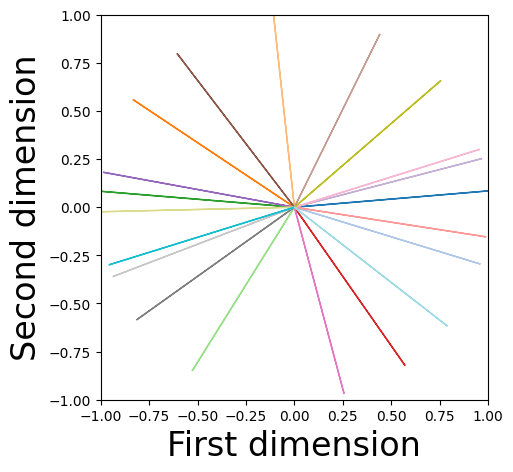

In [9]:
# The following projects the neurons onto e1 and e2:
def get_cmap(n, name='tab20'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

size=24
color = get_cmap(K)

plt.figure(figsize=(5,5))

for i in range(K):
    plt.arrow(0, 0, norm_wts[i,0], norm_wts[i,1], color=color(i))
plt.xlabel('First dimension', fontsize=size)
plt.ylabel('Second dimension', fontsize=size)
plt.xlim((-1, 1))
plt.ylim((-1, 1))




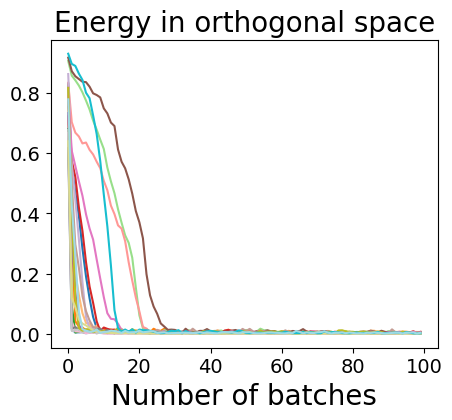

In [11]:
# when noise is small, and number of neurons are not too large, signal energy bumps up very quickly, within a few batches of the first epoch (for large LR only) for data model 2
num_batches_plot = 100
epoch_num = 0
plt.figure(figsize=(5,4))
for i in range(K):
  plt.plot(energy_in_orth_space[epoch_num,0:num_batches_plot,i].detach().numpy(), color=color(i))
plt.title('Energy in orthogonal space', fontsize=20)
plt.xlabel('Number of batches', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
plt.close()


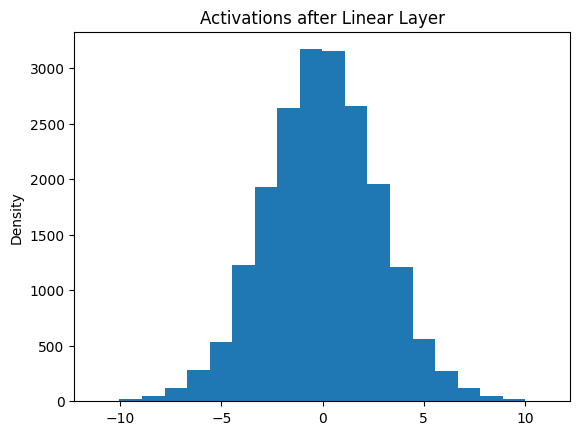

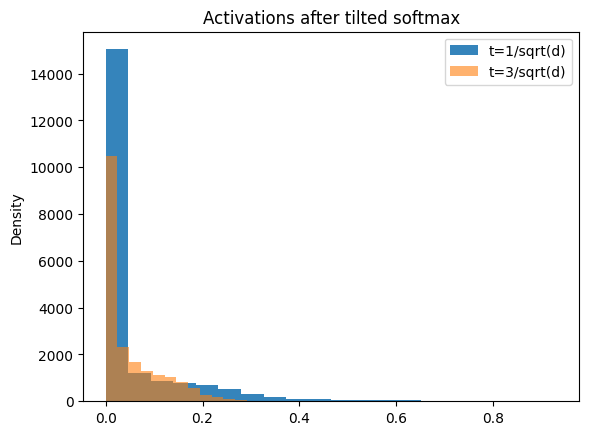

In [12]:
ts_2 = TexpNormalization(tilt=3*t_inf).to(device)
ts_2_output = ts_2(test_acts)

bins=20
plt.figure()
plt.hist(test_acts.cpu().detach().numpy().flatten(), bins=bins)
plt.title('Activations after Linear Layer')
plt.ylabel('Density')
plt.show()
plt.close()

plt.figure()
plt.hist(ts_output.cpu().detach().numpy().flatten(), bins=bins, label = 't=1/sqrt(d)', alpha=0.9)
plt.hist(ts_2_output.cpu().detach().numpy().flatten(), bins=bins, label = 't=3/sqrt(d)', alpha=0.6)
plt.legend()
plt.title('Activations after tilted softmax')
plt.ylabel('Density')
plt.show()
plt.close()
